## Prediction Models
Predict the instrument based on the input csv files from build dataset.
Uses various sklearn classification models and plots error%

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import metrics

### Load the Datasets
Load the data from the created csv files.

In [9]:
df_train = pd.read_csv('./Extracted CSVs/train.csv')
df_valid = pd.read_csv('./Extracted CSVs/valid.csv')
df_test = pd.read_csv('./Extracted CSVs/test.csv')

### Prepare the Datasets
Balances the data so that both classes have equal entries, to help balance the classification of our implementations.

Seperates the target and data of the classes.

In [10]:
def equalize_data(class1, class2):
    class1_copy = class1
    class2_copy = class2  
   
    if (class1_copy['y_harmonic'].count() < class2_copy['y_harmonic'].count()):
        while (class1_copy['y_harmonic'].count()<class2_copy['y_harmonic'].count()): 
            temp = [class1_copy, class1]
            class1_copy = pd.concat(temp)
        class1_copy = class1_copy[:class2_copy['y_harmonic'].count()]
    else:
        while (class2_copy['y_harmonic'].count()<class1_copy['y_harmonic'].count()):
            temp = [class2_copy, class2]
            class2_copy = pd.concat(temp)
        class2_copy = class2_copy[:class1_copy['y_harmonic'].count()]
    return (pd.concat([class1_copy, class2_copy]))

def count_errors(predictions):
    count = 0;
    for pred in predictions:
        if (pred[0] != pred[1]):
            count += 1
    return count;

# balance the datasets
input_df_train = equalize_data(df_train[df_train['target'] == 0], df_train[df_train['target'] == 1])
input_df_valid = equalize_data(df_valid[df_valid['target'] == 0], df_valid[df_valid['target'] == 1])
input_df_test = equalize_data(df_test[df_test['target'] == 0], df_test[df_test['target'] == 1])

# randomize datasets
input_df_train = input_df_train.sample(frac=1).reset_index(drop=True)
input_df_valid = input_df_valid.sample(frac=1).reset_index(drop=True)
input_df_test = input_df_test.sample(frac=1).reset_index(drop=True)

# Separate the target and the columns
y_train = input_df_train['target']
x_train = input_df_train.drop(labels=['target'], axis=1)
#Remove the string column
x_train = x_train.drop(x_train.columns[0], axis=1)

# Separate the target and the columns
y_valid = input_df_valid['target']
x_valid = input_df_valid.drop(labels=['target'], axis=1)
#Remove the string column
x_valid = x_valid.drop(x_valid.columns[0], axis=1)

# Separate the target and the columns
y_test = input_df_test['target']
x_test = input_df_test.drop(labels=['target'], axis=1)
#Remove the string column
x_test = x_test.drop(x_test.columns[0], axis=1)

data_length_train = len(x_train)
data_length_valid = len(x_valid)
data_length_test = len(x_test)

### Format Results
These functions provide formatting for results. Using Graphs to display error rate and calculate accuracy, precision and recall of each classifier. 

Note: These functions use confusion matrices from SKLearn. These are in the form of:
Uses
[[True Positives,False Positives],
[False Negatives, True Negatives]]

References: https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

In [11]:
"""
Name: display_metrics
Input: 
    conf_matrix_train: Confusion Matrix from train set prediction
    conf_matrix_valid: Confusion Matrix from validation set prediction
    conf_matrix_test: Confusion Matrix from test set prediction
Returns: None

Calls functions to print the accuracy,precision and recall of a model


Uses Confusion Matrix in form of:
[[True Positives,False Positives],
[False Negatives, True Negatives]]
"""
def display_metrics(conf_matrix_train, conf_matrix_valid, conf_matrix_test, classifier):
    print(classifier + ' Results')
    display_error_graph(conf_matrix_train, conf_matrix_valid, conf_matrix_test, classifier)
    print('Accuracy:')
    print_accuracy(conf_matrix_train, conf_matrix_valid, conf_matrix_test)
    print('Precision:')
    print_precision(conf_matrix_train, conf_matrix_valid, conf_matrix_test)
    print('Recall:')
    print_recall(conf_matrix_train, conf_matrix_valid, conf_matrix_test)

"""
Name: display_error_graph
Input: 
    conf_matrix_train: Confusion Matrix from train set prediction
    conf_matrix_valid: Confusion Matrix from validation set prediction
    conf_matrix_test: Confusion Matrix from test set prediction
    classifier: Name of Classifier
    fig_num: Figure number to use
Returns: None

Outputs a graph of the correct / total cases percentage for train, valid and test
"""
def display_error_graph(conf_matrix_train, conf_matrix_valid, conf_matrix_test, classifier):
    num_errors_train = conf_matrix_train[0][1] + conf_matrix_train[1][0]
    num_errors_valid = conf_matrix_valid[0][1] + conf_matrix_valid[1][0]
    num_errors_test  = conf_matrix_test[0][1]  + conf_matrix_test[1][0]
    
    error_percent_train = round(num_errors_train / data_length_train * 100, 2);
    error_percent_valid = round(num_errors_valid / data_length_valid * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)
    
    plt.title("Error in Train, Validation and Test for: " + classifier)
    plt.ylabel("Error (%)")
    plt.bar('Train', error_percent_train)
    plt.bar('Validation', error_percent_valid)
    plt.bar('Test', error_percent_test)
    plt.show()

"""
Name: print_accuracy
Input:
    conf_matrix_train: Confusion Matrix from train set prediction
    conf_matrix_valid: Confusion Matrix from validation set prediction
    conf_matrix_test: Confusion Matrix from test set prediction
Returns: None

Calculates the accuracy of the model:
Correct over total predictions
Accuracy = TP + TN / TP+TN+FP+FN
"""
def print_accuracy(conf_matrix_train, conf_matrix_valid, conf_matrix_test):
    accuracy_percent_train = round((conf_matrix_train[0][0] + conf_matrix_train[1][1]) / data_length_train * 100, 2)
    accuracy_percent_valid = round((conf_matrix_valid[0][0] + conf_matrix_valid[1][1]) / data_length_valid * 100, 2)
    accuracy_percent_test =  round((conf_matrix_test[0][0]  + conf_matrix_test[1][1])  / data_length_test  * 100, 2)
    print('Train set accuracy: ', accuracy_percent_train, '%')
    print('Validation set accuracy: ', accuracy_percent_valid, '%')
    print('Test set accuracy: ', accuracy_percent_test, '%')

"""
Name: print_precision
Input:
    conf_matrix_train: Confusion Matrix from train set prediction
    conf_matrix_valid: Confusion Matrix from validation set prediction
    conf_matrix_test: Confusion Matrix from test set prediction
Returns: None

Calculates the precision of the model:
What proportion of positive identifications was actually correct?
Precision = TP/TP+FP
"""
def print_precision(conf_matrix_train, conf_matrix_valid, conf_matrix_test):
    recall_train = round(conf_matrix_train[0][0] / (conf_matrix_train[0][0] + conf_matrix_train[0][1]) * 100, 2)
    recall_valid = round(conf_matrix_valid[0][0] / (conf_matrix_valid[0][0] + conf_matrix_valid[0][1]) * 100, 2)
    recall_test =  round(conf_matrix_test[0][0]  / (conf_matrix_test[0][0]  + conf_matrix_test[0][1])  * 100, 2)
    print('Train set precision: ', recall_train, '%')
    print('Validation set precision: ', recall_valid, '%')
    print('Test set precision: ', recall_test, '%')

"""
Name: print_recall
Input:
    conf_matrix_train: Confusion Matrix from train set prediction
    conf_matrix_valid: Confusion Matrix from validation set prediction
    conf_matrix_test: Confusion Matrix from test set prediction
Returns: None


Calculates the recall of the model:
What proportion of actual positives was identified correctly?
Recall = TP/ TP+FN 
"""
def print_recall(conf_matrix_train, conf_matrix_valid, conf_matrix_test):
    recall_train = round(conf_matrix_train[0][0] / (conf_matrix_train[0][0] + conf_matrix_train[1][0]) * 100, 2)
    recall_valid = round(conf_matrix_valid[0][0] / (conf_matrix_valid[0][0] + conf_matrix_valid[1][0]) * 100, 2)
    recall_test =  round(conf_matrix_test[0][0]  / (conf_matrix_test[0][0]  + conf_matrix_test[1][0])  * 100, 2)
    print('Train set recall: ', recall_train, '%')
    print('Validation set recall: ', recall_valid, '%')
    print('Test set recall: ', recall_test, '%')

### Binary Decision Tree
The first algorithm we used was a Binary Decision Tree. The tree was created and fit to the data using a Sci-kit learn decision tree. Sci-kit learn uses an optimised version of the Classification and Regression Trees (CART) algorithm to construct its decision trees. The CART algorithm “constructs binary trees using the feature and threshold that yield the largest information gain at each node.”

Reference: https://scikit-learn.org/stable/modules/tree.html

In [6]:
def simple_decision_tree(max_depth):
    # hyperparameters
    # max_depth of 4 seems to work well for training with validation set

    # create a scikit-learn tree based on validation set
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf = clf.fit(x_valid, y_valid)

    # make predictions
    predictions_test = np.vstack((y_test, clf.predict(x_test).tolist())).T
    predictions_valid = np.vstack((y_valid, clf.predict(x_valid).tolist())).T

    num_errors_test = count_errors(predictions_test)
    num_errors_valid = count_errors(predictions_valid)

    # calculating valid and test error to two decimal places
    error_percent_valid = round(num_errors_valid / data_length_valid * 100, 2);
    error_percent_test = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Validation Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Decision Tree: Error in Validation vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Valid', error_percent_valid)
    plt.bar('Test', error_percent_test)

    print('Validation set error percentage: ', error_percent_valid)
    print('Test set error percentage: ', error_percent_test)


Validation set error percentage:  0.0
Test set error percentage:  1.31


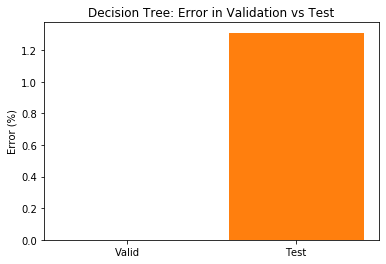

In [19]:
# fit a tree to our data and plot error
simple_decision_tree(4)

### Random Forest
The forest was created and fit to the data using a Sci-kit learn random forest. A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

Hyperparameter tuning was done using the Sci-kit learn RandomizedSearchCV function. This takes a range of input values for various hyperparameters and randomly tests different configurations. It saves the best performing model, which is used to make predictions for the test set.

Reference: https://scikit-learn.org/stable/modules/ensemble.html#forest

In [23]:
# random forest implementation
def random_forest():
    # hyperparameter training. Uses sklearn Random Search
    random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(1, 10, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [1, 2, 3, 4, 10],
               'min_samples_split': [2, 3, 4, 7],
               'n_estimators': list(np.linspace(10, 150, 10, dtype = int))}

    clf = RandomForestClassifier()
    model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 10, 
                                   cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
    model.fit(x_train,y_train)

    # make predictions
    predictions_train = model.best_estimator_.predict(x_train)
    predictions_valid = model.best_estimator_.predict(x_valid)
    predictions_test = model.best_estimator_.predict(x_test)

    # make a confusion matrix
    results_train = confusion_matrix(y_train, predictions_train)
    results_valid = confusion_matrix(y_valid, predictions_valid)
    results_test = confusion_matrix(y_test, predictions_test)
    display_metrics(results_train, results_valid, results_test, "Random Forest")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  1.3min remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished


Random Forest Results


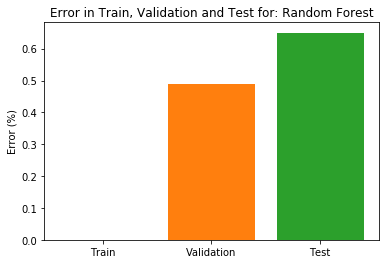

Accuracy:
Train set accuracy:  100.0 %
Validation set accuracy:  99.51 %
Test set accuracy:  99.35 %
Precision:
Train set precision:  100.0 %
Validation set precision:  100.0 %
Test set precision:  100.0 %
Recall:
Train set recall:  100.0 %
Validation set recall:  99.03 %
Test set recall:  98.71 %


In [24]:
# fit a tree to our data and plot error
random_forest()

### AdaBoost
The second algorithm used was AdaBoost which was implemented with Sci-kit learn. Sci-kit learn allows you to define a base estimator which defaults to a DecisionTreeClassifier with a max depth of 1. An estimator is a simple model that can give a classification. Sci-kit learn implements the AdaBoost algorithm to apply heavier weights to specific training estimators with the goal of correcting wrong predictions.

Takes max number of estimators to use, it then uses the train and validation sets to tune the hypeparameters and pick the best outcome. 

Reference: https://scikit-learn.org/stable/modules/ensemble.html#adaboost  

In [12]:
def ada_boost(max_estimators):
    train_results = []
    valid_results = []
    #Tune the hyperparameter estimators
    for estimators in range(1,  max_estimators):
        classifier = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1),
            n_estimators=estimators
        )
        classifier.fit(x_train, y_train)
        predictions_train = classifier.predict(x_train)
        results_train = confusion_matrix(y_train, predictions_train)
        num_errors_train = results_train[0][1] + results_train[1][0]
        train_results.append(num_errors_train)
        predictions_valid = classifier.predict(x_valid)
        results_valid = confusion_matrix(y_valid, predictions_valid)
        num_errors_valid = results_valid[0][1] + results_valid[1][0]
        valid_results.append(num_errors_valid)
        
    estimator_indices = np.arange(1,max_estimators)
    plt.figure(0)
    plt.plot(estimator_indices, train_results, color='r' , label='Train Error')
    plt.plot(estimator_indices, valid_results, color='b' , label='Valid Error')
    plt.legend()
    plt.show()
    
    #Combine the error for each set
    error_results = np.arange(1,max_estimators)
    for i in range(0, len(train_results)):
        error_results[i] = train_results[i] + valid_results[i]
    print(error_results)
    
    best_estimator = np.argmin(error_results) + 1
    print('The Best Estimator found is: ', best_estimator)
    
    classifier = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1),
            n_estimators=best_estimator
    )
    classifier.fit(x_train, y_train)
    
    predictions_train = classifier.predict(x_train)
    results_train = confusion_matrix(y_train, predictions_train)
    
    predictions_valid = classifier.predict(x_valid)
    results_valid = confusion_matrix(y_valid, predictions_valid)
    
    predictions_test = classifier.predict(x_test)
    results_test = confusion_matrix(y_test, predictions_test)
    display_metrics(results_train, results_valid, results_test, "AdaBoost")

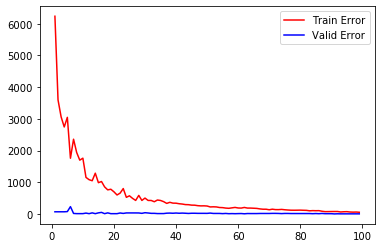

[6304 3668 3130 2814 3123 1991 2376 1952 1710 1772 1183 1093 1085 1298
 1024 1075  866  797  792  711  611  691  821  560  608  527  462  620
  449  543  460  448  408  455  441  404  361  398  367  372  348  343
  321  312  304  302  284  277  279  272  252  245  241  223  213  205
  190  207  218  203  202  214  202  201  196  191  178  168  168  151
  172  159  156  158  152  144  135  134  135  137  133  130  116  117
  119  116  104   85   86   88   82   86   69   76   79   68   64   67
   60]
The Best Estimator found is:  99
AdaBoost Results


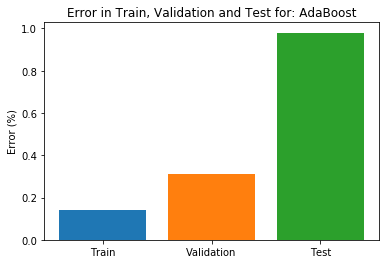

Accuracy:
Train set accuracy:  99.86 %
Validation set accuracy:  99.69 %
Test set accuracy:  99.02 %
Precision:
Train set precision:  99.85 %
Validation set precision:  100.0 %
Test set precision:  100.0 %
Recall:
Train set recall:  99.87 %
Validation set recall:  99.39 %
Test set recall:  98.08 %


In [13]:
ada_boost(50)

### KNN
K Nearest Neighbor (KNN) Classifier. The classifier was created using the Sci-kit learn KNeighborsClassifier function. This function uses the minkowski distance to compute the distance between points. After some initial tuning of the hyperparameter K, we found that the best value to use for our dataset was K = 27.


In [14]:
def KNN(k):
    KNN_Classifier = KNeighborsClassifier(n_neighbors = k)
    KNN_Classifier.fit(x_train, y_train)
    
    predictions_train = KNN_Classifier.predict(x_train)
    predictions_valid = KNN_Classifier.predict(x_valid)
    predictions_test = KNN_Classifier.predict(x_test)
    
    results_train = confusion_matrix(y_train, predictions_train)
    results_valid = confusion_matrix(y_valid, predictions_valid)
    results_test = confusion_matrix(y_test, predictions_test)
    
    display_metrics(results_train, results_valid, results_test, "KNN")    

KNN Results


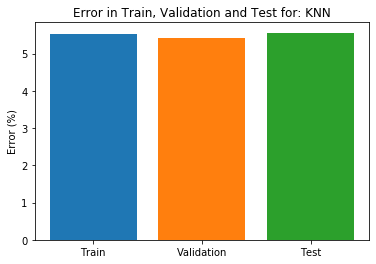

Accuracy:
Train set accuracy:  94.48 %
Validation set accuracy:  94.59 %
Test set accuracy:  94.44 %
Precision:
Train set precision:  96.32 %
Validation set precision:  93.86 %
Test set precision:  93.46 %
Recall:
Train set recall:  92.9 %
Validation set recall:  95.26 %
Test set recall:  95.33 %


In [15]:
KNN(27)

# Support Vector Machines
Our final prediction model - Support Vector Machines, implemented with Scikit-Learn. This Support Vector Machine (SVM) uses the rbf kernel, with a gamma of 0.00001 and c of 100. This configuration was chosen after testing 25 combonations of gamma and c, following logarithmic increments of each. The SVM is very sensitive to the gamma parameter. A smaller gamma than used would fail to capture the shape, being too constrictive. In SVMs, smaller values of c lead to simpler decision functions. Larger values are more complex. We found 100 did not sacrifice accuracy for efficiency.

In [16]:
def runSVM(k, c, g):   
    x_train_svm=x_train
    x_test_svm = x_test
    x_valid_svm = x_valid

    x_train_svm = x_train_svm.to_numpy()
    x_test_svm = x_test_svm.to_numpy()
    x_valid_svm= x_valid_svm.to_numpy()

    y_train_svm = y_train
    y_train_svm = y_train_svm.values
    
    clf = svm.SVC(kernel=k, C=c, gamma=g)
    clf.fit(x_train, y_train)

    predictions_train = clf.predict(x_train)        
    predictions_valid = clf.predict(x_valid)
    predictions_test = clf.predict(x_test)

    results_train = confusion_matrix(y_train, predictions_train)
    results_valid = confusion_matrix(y_valid, predictions_valid)
    results_test = confusion_matrix(y_test, predictions_test)
    
    display_metrics(results_train, results_valid, results_test, "SVM")

SVM Results


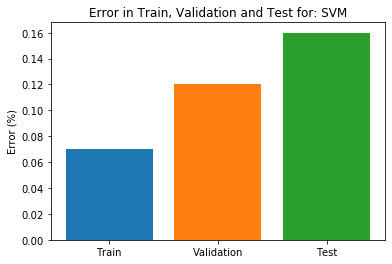

Accuracy:
Train set accuracy:  99.93 %
Validation set accuracy:  99.88 %
Test set accuracy:  99.84 %
Precision:
Train set precision:  99.97 %
Validation set precision:  100.0 %
Test set precision:  99.67 %
Recall:
Train set recall:  99.89 %
Validation set recall:  99.75 %
Test set recall:  100.0 %


In [17]:
runSVM('rbf', 100, 0.00001)